In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

In [7]:
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = pd.read_csv('../data/Î¨¥_ÏõîÏ∞®ÎÇºÍ≤åÏöî.csv', encoding='cp949')
df_grow = pd.read_csv('../data/factor_external_weekly_ver_0721.csv', encoding='utf-8')

In [8]:
df['Ï¥ùÍ±∞ÎûòÎüâ(kg)'] = np.log1p(df['Ï¥ùÍ±∞ÎûòÎüâ(kg)'])

In [9]:
df.head()


year  week  week_start  ÌíàÏ¢ÖÏΩîÎìú  Îì±Í∏âÏΩîÎìú  ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú  Ï¥ùÍ±∞ÎûòÎüâ(kg)      ÏùºÌèâÍ∑†Í∏∞Ïò®  ÏµúÍ≥†Í∏∞Ïò®  \
0  2018    13  2018-03-26   100    11    1079  7.365813  16.800000  24.1   
1  2018    13  2018-03-26   100    11    1137  9.261129  13.600000  17.6   
2  2018    13  2018-03-26   100    11    1170  6.398595  15.600000  19.3   
3  2018    13  2018-03-26   100    12    1000  8.692994  11.000000  18.1   
4  2018    13  2018-03-26   100    12    1079  7.090910  14.333333  23.4   

   ÏµúÏ†ÄÍ∏∞Ïò®  ...  ÏµúÏ†ÄÍ∏∞Ïò®_t-2  ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-2  Í∞ïÏàòÎüâ(mm)_t-2  1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-2  ÏùºÌèâÍ∑†Í∏∞Ïò®_t-3  \
0  12.3  ...    -6.550   52.208333        1.050               0.0  -0.685417   
1   9.4  ...     0.975   62.008333        1.375               0.0   7.069048   
2  12.0  ...     0.550   57.207500        3.500               0.0   6.950000   
3   5.3  ...    -9.575   54.875000        1.750               0.0  -3.384821   
4   7.0  ...    -5.875   55.605000        0.200               0.0   1.635000   

   ÏµúÍ≥†Í∏∞Ïò®_t-3  ÏµúÏ†ÄÍ∏∞Ïò®_t-3  ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-3  Í∞ïÏàòÎüâ(mm)_t-3  1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-3  
0     5.000    -5.525   72.120833        5.300               0.0  
1    12.675     3.300   71.919048        9.900               0.0  
2    11.250     3.175   69.987500        7.400               0.0  
3     3.275    -7.000   52.450893        1.050               0.0  
4     7.225    -3.075   69.767500        8.275               0.0  

[5 rows x 35 columns]

In [10]:
# year, week ÌååÏÉù
def format_week_int(weekno):
    year = weekno // 100
    week = weekno % 100
    return year, week

df_grow[['year', 'week']] = df_grow['weekno'].apply(lambda x: pd.Series(format_week_int(x)))
df_grow.drop(columns='weekno', inplace=True)

# Î≥ëÌï© Ï†Ñ ÌíàÎ™©ÏΩîÎìú Ï∂îÍ∞Ä
df['item_code'] = 1101

# Ïô∏ÏÉùÎ≥ÄÏàò Î≥ëÌï©
df = pd.merge(
    df,
    df_grow[['year', 'week', 'item_code', 'holiday_flag', 'holiday_score', 'grow_score']],
    on=['year', 'week', 'item_code'],
    how='left'
)

# Î≥ëÌï© ÌõÑ Ïô∏ÏÉùÎ≥ÄÏàò Ïª¨Îüº Ïû¨Ï†ïÏùò
for col in ['holiday_flag', 'holiday_score', 'grow_score']:
    if f"{col}_y" in df.columns:
        df[col] = df[f"{col}_y"]
        df.drop(columns=[f"{col}_x", f"{col}_y"], inplace=True)
df.drop(columns='item_code', inplace=True)

In [11]:
df.columns

Index(['year', 'week', 'week_start', 'ÌíàÏ¢ÖÏΩîÎìú', 'Îì±Í∏âÏΩîÎìú', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'Ï¥ùÍ±∞ÎûòÎüâ(kg)',
       'ÏùºÌèâÍ∑†Í∏∞Ïò®', 'ÏµúÍ≥†Í∏∞Ïò®', 'ÏµúÏ†ÄÍ∏∞Ïò®', 'ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ', 'Í∞ïÏàòÎüâ(mm)', '1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)', 'ÌèâÍ∑†Îã®Í∞Ä(Ïõê)',
       'ÏùºÌèâÍ∑†Í∏∞Ïò®_t-1', 'ÏµúÍ≥†Í∏∞Ïò®_t-1', 'ÏµúÏ†ÄÍ∏∞Ïò®_t-1', 'ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-1', 'Í∞ïÏàòÎüâ(mm)_t-1',
       '1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-1', 'ÏùºÌèâÍ∑†Í∏∞Ïò®_t-2', 'ÏµúÍ≥†Í∏∞Ïò®_t-2', 'ÏµúÏ†ÄÍ∏∞Ïò®_t-2', 'ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-2',
       'Í∞ïÏàòÎüâ(mm)_t-2', '1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-2', 'ÏùºÌèâÍ∑†Í∏∞Ïò®_t-3', 'ÏµúÍ≥†Í∏∞Ïò®_t-3', 'ÏµúÏ†ÄÍ∏∞Ïò®_t-3',
       'ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-3', 'Í∞ïÏàòÎüâ(mm)_t-3', '1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-3', 'holiday_flag',
       'holiday_score', 'grow_score'],
      dtype='object')

In [12]:
# 0. ÏµúÏÜå Ïó∞ÎèÑ ÌôïÏù∏ (Ïòà: 2018)
min_year = df['year'].min()

# 1. Î≥ëÌï© ÎåÄÏÉÅ ÌÖåÏù¥Î∏î ÏÉùÏÑ± (Ï§ëÎ≥µ Ï†úÍ±∞ Ï§ëÏöî!)
price_lag = (
    df[['year', 'week', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú', 'ÌèâÍ∑†Îã®Í∞Ä(Ïõê)']]
    .drop_duplicates(subset=['year', 'week', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú'])
    .copy()
)
price_lag['year'] += 1
price_lag = price_lag.rename(columns={'ÌèâÍ∑†Îã®Í∞Ä(Ïõê)': 'price_lag_1y'})

# 2. Î≥ëÌï© ÏàòÌñâ (1:1 Î≥¥Ïû•)
df = pd.merge(
    df,
    price_lag,
    on=['year', 'week', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú'],
    how='left'
)

# 3. Ïõî Í∏∞Ï§Ä ÌèâÍ∑†Îã®Í∞ÄÎ°ú Î≥¥ÏôÑ
df['month'] = pd.to_datetime(df['week_start']).dt.month

monthly_avg = (
    df[['year', 'month', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú', 'ÌèâÍ∑†Îã®Í∞Ä(Ïõê)']]
    .groupby(['year', 'month', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú'], as_index=False)
    .mean()
)

monthly_avg['year'] += 1
monthly_avg = monthly_avg.rename(columns={'ÌèâÍ∑†Îã®Í∞Ä(Ïõê)': 'price_lag_month_fill'})

df = pd.merge(
    df,
    monthly_avg,
    on=['year', 'month', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú'],
    how='left'
)

# üìå ÏõîÌèâÍ∑†ÏúºÎ°ú Î≥¥ÏôÑ (Îã®, ÏµúÏÜå Ïó∞ÎèÑÎäî Ï†úÏô∏)
df['price_lag_1y'] = df.apply(
    lambda row: row['price_lag_month_fill']
    if pd.isna(row['price_lag_1y']) and row['year'] > min_year
    else row['price_lag_1y'],
    axis=1
)

# 4. Ïó∞ ÌèâÍ∑†ÏúºÎ°ú fallback
yearly_avg = (
    df[['year', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú', 'ÌèâÍ∑†Îã®Í∞Ä(Ïõê)']]
    .groupby(['year', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú'], as_index=False)
    .mean()
)
yearly_avg['year'] += 1
yearly_avg = yearly_avg.rename(columns={'ÌèâÍ∑†Îã®Í∞Ä(Ïõê)': 'price_lag_fallback'})

df = pd.merge(
    df,
    yearly_avg,
    on=['year', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú'],
    how='left'
)

df['price_lag_1y'] = df.apply(
    lambda row: row['price_lag_fallback']
    if pd.isna(row['price_lag_1y']) and row['year'] > min_year
    else row['price_lag_1y'],
    axis=1
)
df.dropna(subset=['price_lag_1y'], inplace=True)

In [13]:
print("Î≥ëÌï© ÌõÑ Ìñâ Ïàò:", len(df))
print("NaN ÎπÑÏú®:", df['price_lag_1y'].isna().mean())

Î≥ëÌï© ÌõÑ Ìñâ Ïàò: 74775
NaN ÎπÑÏú®: 0.0


In [14]:
# df.sample(5)

In [15]:
print("ÎÇ®ÏùÄ Ïª¨Îüº:\n", df.columns.tolist())


ÎÇ®ÏùÄ Ïª¨Îüº:
 ['year', 'week', 'week_start', 'ÌíàÏ¢ÖÏΩîÎìú', 'Îì±Í∏âÏΩîÎìú', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'Ï¥ùÍ±∞ÎûòÎüâ(kg)', 'ÏùºÌèâÍ∑†Í∏∞Ïò®', 'ÏµúÍ≥†Í∏∞Ïò®', 'ÏµúÏ†ÄÍ∏∞Ïò®', 'ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ', 'Í∞ïÏàòÎüâ(mm)', '1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)', 'ÌèâÍ∑†Îã®Í∞Ä(Ïõê)', 'ÏùºÌèâÍ∑†Í∏∞Ïò®_t-1', 'ÏµúÍ≥†Í∏∞Ïò®_t-1', 'ÏµúÏ†ÄÍ∏∞Ïò®_t-1', 'ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-1', 'Í∞ïÏàòÎüâ(mm)_t-1', '1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-1', 'ÏùºÌèâÍ∑†Í∏∞Ïò®_t-2', 'ÏµúÍ≥†Í∏∞Ïò®_t-2', 'ÏµúÏ†ÄÍ∏∞Ïò®_t-2', 'ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-2', 'Í∞ïÏàòÎüâ(mm)_t-2', '1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-2', 'ÏùºÌèâÍ∑†Í∏∞Ïò®_t-3', 'ÏµúÍ≥†Í∏∞Ïò®_t-3', 'ÏµúÏ†ÄÍ∏∞Ïò®_t-3', 'ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-3', 'Í∞ïÏàòÎüâ(mm)_t-3', '1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-3', 'holiday_flag', 'holiday_score', 'grow_score', 'price_lag_1y', 'month', 'price_lag_month_fill', 'price_lag_fallback']


In [16]:
# y, X Î∂ÑÎ¶¨
y = df['ÌèâÍ∑†Îã®Í∞Ä(Ïõê)']
X = df.drop(columns=['ÌèâÍ∑†Îã®Í∞Ä(Ïõê)'])

In [17]:
def generate_moving_averages_fixed(df, target_col='ÌèâÍ∑†Îã®Í∞Ä(Ïõê)', group_cols=['ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú'], windows=[4, 13, 26]):
    """
    Îç∞Ïù¥ÌÑ∞ ÎàÑÏàòÎ•º Î∞©ÏßÄÌïòÍ≥† Ïù¥ÎèôÌèâÍ∑† ÌîºÏ≤òÎ•º ÏÉùÏÑ±ÌïòÎäî ÏàòÏ†ïÎêú Ìï®Ïàò
    """
    df = df.sort_values(group_cols + ['year', 'week']).copy()

    # 1. Í∑∏Î£πÎ≥ÑÎ°ú target Í∞íÏùÑ shiftÌïòÏó¨ ÏûÑÏãú Ïª¨Îüº ÏÉùÏÑ± (Îç∞Ïù¥ÌÑ∞ ÎàÑÏàò Î∞©ÏßÄ)
    df['shifted_target'] = df.groupby(group_cols)[target_col].shift(1)

    # 2. shiftÎêú Ïª¨ÎüºÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Ïù¥Îèô ÌÜµÍ≥Ñ ÌîºÏ≤ò Í≥ÑÏÇ∞
    for w in windows:
        df[f'SMA_{w}'] = df.groupby(group_cols)['shifted_target'].transform(
            lambda x: x.rolling(window=w, min_periods=1).mean()
        )
        df[f'EMA_{w}'] = df.groupby(group_cols)['shifted_target'].transform(
            lambda x: x.ewm(span=w, adjust=False).mean()
        )

    # 3. ÏúÑÏóêÏÑú Í≥ÑÏÇ∞Îêú EMA ÌîºÏ≤òÎ•º Í∏∞Î∞òÏúºÎ°ú ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ±
    df['EMA4_SMA4_diff'] = df['EMA_4'] - df['SMA_4']
    df['EMA13_SMA13_diff'] = df['EMA_13'] - df['SMA_13']
    df['EMA26_SMA26_diff'] = df['EMA_26'] - df['SMA_26']

    df['EMA_4_rate'] = df.groupby(group_cols)['EMA_4'].transform(lambda x: x.pct_change().fillna(0))
    df['EMA_13_rate'] = df.groupby(group_cols)['EMA_13'].transform(lambda x: x.pct_change().fillna(0))
    df['EMA_26_rate'] = df.groupby(group_cols)['EMA_26'].transform(lambda x: x.pct_change().fillna(0))

    # 4. ÏûÑÏãúÎ°ú ÏÇ¨Ïö©Ìïú Ïª¨Îüº Ï†úÍ±∞
    df = df.drop(columns=['shifted_target'])

    return df

# ÏàòÏ†ïÎêú Ìï®ÏàòÎ•º Ìò∏Ï∂úÌï©ÎãàÎã§.
df_fixed = generate_moving_averages_fixed(df)

moving_avg_cols = [
    'SMA_4', 'SMA_13', 'SMA_26',
    'EMA_4', 'EMA_13', 'EMA_26',
    'EMA4_SMA4_diff', 'EMA13_SMA13_diff', 'EMA26_SMA26_diff',
    'EMA_4_rate', 'EMA_13_rate', 'EMA_26_rate', 'holiday_flag',
    'holiday_score', 'grow_score', 'price_lag_1y'
]

# df_final Ïù¥ÎùºÎäî ÏÉà Î≥ÄÏàòÏóê Í≤∞Ï∏°Í∞íÏù¥ Ï†úÍ±∞Îêú ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞Î•º Ï†ÄÏû•
df = df_fixed.dropna(subset=moving_avg_cols).copy()

# 1. Îã®Í∏∞ ÏãúÏ∞®(Lag) ÌîºÏ≤ò Ï∂îÍ∞Ä
print("Îã®Í∏∞ ÏãúÏ∞® ÌîºÏ≤òÎ•º Ï∂îÍ∞ÄÌï©ÎãàÎã§...")

# Í∑∏Î£πÎ≥Ñ(ÏÇ∞ÏßÄ-ÌíàÏ¢Ö)Î°ú Ïù¥Ï†Ñ 1Ï£º, 2Ï£º, 3Ï£ºÏ∞®Ïùò Îã®Í∞ÄÎ•º Í∞ÄÏ†∏ÏòµÎãàÎã§.
group_cols = ['ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú']
lags = [1, 2, 3]

for lag in lags:
    col_name = f'price_lag_{lag}w' # Ïª¨Îüº Ïù¥Î¶Ñ Ïòà: price_lag_1w
    df[col_name] = df.groupby(group_cols)['ÌèâÍ∑†Îã®Í∞Ä(Ïõê)'].shift(lag)
    print(f"'{col_name}' ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å.")

# 2. ÏãúÏ∞® ÌîºÏ≤ò ÏÉùÏÑ± ÌõÑ ÏÉùÍ∏¥ Í≤∞Ï∏°Í∞í(NaN) Ï≤òÎ¶¨
# Í∞Å Í∑∏Î£πÏùò Îß® ÏïûÎ∂ÄÎ∂ÑÏóêÎäî Ïù¥Ï†Ñ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ NaNÏù¥ Î∞úÏÉùÌï©ÎãàÎã§.
# Ïù¥ ÌñâÎì§ÏùÄ Î™®Îç∏ ÌïôÏäµÏóê ÏÇ¨Ïö©Ìï† Ïàò ÏóÜÏúºÎØÄÎ°ú Ï†úÍ±∞Ìï©ÎãàÎã§.
print("\\nÏãúÏ∞® ÌîºÏ≤ò ÏÉùÏÑ±ÏúºÎ°ú Ïù∏Ìï¥ Î∞úÏÉùÌïú Í≤∞Ï∏°Í∞íÏùÑ Ï†úÍ±∞Ìï©ÎãàÎã§...")
original_rows = len(df)
df.dropna(inplace=True) # Î™®Îì† NaNÏùÑ Í∞ÄÏßÑ ÌñâÏùÑ Ï†úÍ±∞
new_rows = len(df)
print(f"{original_rows - new_rows}Í∞úÏùò ÌñâÏù¥ Ï†úÍ±∞ÎêòÏóàÏäµÎãàÎã§.")

# 3. Ï∂îÍ∞ÄÎêú ÌîºÏ≤ò ÌôïÏù∏
print("\nÏ∂îÍ∞ÄÎêú ÏãúÏ∞® ÌîºÏ≤ò ÌôïÏù∏:")
print(df[['year', 'week', 'ÌèâÍ∑†Îã®Í∞Ä(Ïõê)', 'price_lag_1w', 'price_lag_2w', 'price_lag_3w']].head())


C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\232601529.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['EMA_4_rate'] = df.groupby(group_cols)['EMA_4'].transform(lambda x: x.pct_change().fillna(0))
C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\232601529.py:25: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['EMA_13_rate'] = df.groupby(group_cols)['EMA_13'].transform(lambda x: x.pct_change().fillna(0))
C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\232601529.py:26: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future v

Îã®Í∏∞ ÏãúÏ∞® ÌîºÏ≤òÎ•º Ï∂îÍ∞ÄÌï©ÎãàÎã§...
'price_lag_1w' ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å.
'price_lag_2w' ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å.
'price_lag_3w' ÌîºÏ≤ò ÏÉùÏÑ± ÏôÑÎ£å.
\nÏãúÏ∞® ÌîºÏ≤ò ÏÉùÏÑ±ÏúºÎ°ú Ïù∏Ìï¥ Î∞úÏÉùÌïú Í≤∞Ï∏°Í∞íÏùÑ Ï†úÍ±∞Ìï©ÎãàÎã§...
11620Í∞úÏùò ÌñâÏù¥ Ï†úÍ±∞ÎêòÏóàÏäµÎãàÎã§.

Ï∂îÍ∞ÄÎêú ÏãúÏ∞® ÌîºÏ≤ò ÌôïÏù∏:
       year  week  ÌèâÍ∑†Îã®Í∞Ä(Ïõê)  price_lag_1w  price_lag_2w  price_lag_3w
12108  2019    18    655.0         516.0         554.0         509.0
12115  2019    18    386.0         655.0         516.0         554.0
12258  2019    19    516.0         386.0         655.0         516.0
12269  2019    19    455.0         516.0         386.0         655.0
12447  2019    20    478.0         455.0         516.0         386.0


In [18]:

# 4Ï£ºÍ∞ÑÏùò Í∞ÄÍ≤© Î≥ÄÎèôÏÑ±(ÌëúÏ§ÄÌé∏Ï∞®) ÌîºÏ≤ò ÏÉùÏÑ±
df['price_roll_std_4w'] = df.groupby(['ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú'])['price_lag_1w'].transform(
    lambda x: x.rolling(window=4, min_periods=1).std()
)

# Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨
df.fillna(0, inplace=True)

In [19]:
# Î™®Îç∏ ÌïôÏäµÏö© Ïû¨Î∂ÑÎ¶¨ Î∞è Ï£ºÍ∏∞Ìòï Î≥ÄÏàò Ï≤òÎ¶¨
y = df['ÌèâÍ∑†Îã®Í∞Ä(Ïõê)']
X = df.drop(columns=['ÌèâÍ∑†Îã®Í∞Ä(Ïõê)'])

# ‚úÖ Ïó¨Í∏∞ÏÑú Ï†úÍ±∞ÌïòÎäî Í≤å Î≤†Ïä§Ìä∏!
X = X.drop(columns=[
    'Îì±Í∏âÏΩîÎìú', 'ÏùºÌèâÍ∑†Í∏∞Ïò®', 'ÏµúÍ≥†Í∏∞Ïò®', 'ÏµúÏ†ÄÍ∏∞Ïò®',
    'ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ', 'Í∞ïÏàòÎüâ(mm)', '1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)',
    'month', 'price_lag_month_fill', 'price_lag_fallback'
], errors='ignore')

X['week_start'] = pd.to_datetime(X['week_start'])
X['year'] = X['week_start'].dt.year
X['week'] = X['week_start'].dt.isocalendar().week.astype(int)

X['week_sin'] = np.sin(2 * np.pi * X['week'] / 52)
X['week_cos'] = np.cos(2 * np.pi * X['week'] / 52)
X = X.drop(columns=['week'])


In [20]:
X_train = X[X['year'] < 2025].drop(columns=['week_start'])
y_train = y[X['year'] < 2025]
X_test = X[X['year'] == 2025].drop(columns=['week_start'])
y_test = y[X['year'] == 2025]


In [21]:
from sklearn.preprocessing import RobustScaler

exclude_cols = ['year', 'ÌíàÏ¢ÖÏΩîÎìú', 'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú']  # Î≤îÏ£ºÌòï Î∞è ÏòàÏô∏
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
scale_cols = [col for col in numerical_cols if col not in exclude_cols]

scaler = RobustScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

In [22]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú', 'ÌíàÏ¢ÖÏΩîÎìú']

for col in cat_cols:
    le = LabelEncoder()
    # ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Î°ú Ïù∏ÏΩîÎçî ÌïôÏäµ Î∞è Î≥ÄÌôò
    X_train[col] = le.fit_transform(X_train[col])
    
    # ÎîïÏÖîÎÑàÎ¶¨Î•º ÏÇ¨Ïö©Ìï¥ ÏïåÎ†§ÏßÑ ÎùºÎ≤®Îßå Îß§ÌïëÌïòÎäî mapping ÏÉùÏÑ±
    mapping = {label: i for i, label in enumerate(le.classes_)}
    
    # ÏãúÌóò Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò:
    # .map(mapping) -> ÏïåÎ†§ÏßÑ ÎùºÎ≤®ÏùÄ Ïà´ÏûêÎ°ú Î≥ÄÌôòÌïòÍ≥†, Î™®Î•¥Îäî ÎùºÎ≤®(unseen)ÏùÄ NaNÏúºÎ°ú ÎßåÎì¶
    # .fillna(-1)   -> NaNÏúºÎ°ú Î∞îÎÄê Î™®Î•¥Îäî ÎùºÎ≤®Îì§ÏùÑ -1Î°ú Ï±ÑÏõÄ
    X_test[col] = X_test[col].map(mapping).fillna(-1).astype(int)

    print(f"'{col}' Ïù∏ÏΩîÎî© ÏôÑÎ£å. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò ÏÉàÎ°úÏö¥ ÎùºÎ≤®ÏùÄ -1Î°ú Ï≤òÎ¶¨ÎêòÏóàÏäµÎãàÎã§.")

'ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú' Ïù∏ÏΩîÎî© ÏôÑÎ£å. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò ÏÉàÎ°úÏö¥ ÎùºÎ≤®ÏùÄ -1Î°ú Ï≤òÎ¶¨ÎêòÏóàÏäµÎãàÎã§.
'ÌíàÏ¢ÖÏΩîÎìú' Ïù∏ÏΩîÎî© ÏôÑÎ£å. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò ÏÉàÎ°úÏö¥ ÎùºÎ≤®ÏùÄ -1Î°ú Ï≤òÎ¶¨ÎêòÏóàÏäµÎãàÎã§.


In [23]:
# df.sample(5)
X_train.isna().sum(), X_test.isna().sum()
# train_df.info()
# test_df.info()

(year                 0
 ÌíàÏ¢ÖÏΩîÎìú                 0
 ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú               0
 Ï¥ùÍ±∞ÎûòÎüâ(kg)             0
 ÏùºÌèâÍ∑†Í∏∞Ïò®_t-1            0
 ÏµúÍ≥†Í∏∞Ïò®_t-1             0
 ÏµúÏ†ÄÍ∏∞Ïò®_t-1             0
 ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-1           0
 Í∞ïÏàòÎüâ(mm)_t-1          0
 1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-1     0
 ÏùºÌèâÍ∑†Í∏∞Ïò®_t-2            0
 ÏµúÍ≥†Í∏∞Ïò®_t-2             0
 ÏµúÏ†ÄÍ∏∞Ïò®_t-2             0
 ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-2           0
 Í∞ïÏàòÎüâ(mm)_t-2          0
 1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-2     0
 ÏùºÌèâÍ∑†Í∏∞Ïò®_t-3            0
 ÏµúÍ≥†Í∏∞Ïò®_t-3             0
 ÏµúÏ†ÄÍ∏∞Ïò®_t-3             0
 ÌèâÍ∑†ÏÉÅÎåÄÏäµÎèÑ_t-3           0
 Í∞ïÏàòÎüâ(mm)_t-3          0
 1ÏãúÍ∞ÑÏµúÍ≥†Í∞ïÏàòÎüâ(mm)_t-3     0
 holiday_flag         0
 holiday_score        0
 grow_score           0
 price_lag_1y         0
 SMA_4                0
 EMA_4                0
 SMA_13               0
 EMA_13               0
 SMA_26               0
 EMA_26               0
 EMA4_SMA4_diff       0
 EMA13

In [24]:
# 1. ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
import optuna
from lightgbm import LGBMRegressor # LGBMRegressorÎ°ú Î≥ÄÍ≤Ω
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
# ---------------------------------------------------------------------------

# 2. ÏµúÏ†ÅÌôî Î™©Ìëú(Objective) Ìï®Ïàò Ï†ïÏùò
def objective(trial):
    """OptunaÍ∞Ä ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ï∞æÍ∏∞ ÏúÑÌï¥ Ìò∏Ï∂úÌïòÎäî Ìï®Ïàò"""
    # LGBMRegressorÏóê ÎßûÎäî ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌÉêÏÉâ Î≤îÏúÑ ÏßÄÏ†ï
    params = {
        'objective': 'regression', # ÌöåÍ∑Ä Î¨∏Ï†úÏûÑÏùÑ Î™ÖÏãú
        'metric': 'rmse', # ÌèâÍ∞Ä ÏßÄÌëúÎ•º RMSEÎ°ú ÏÑ§Ï†ï
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0), # L1 Ï†ïÍ∑úÌôî
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0), # L2 Ï†ïÍ∑úÌôî
        'random_state': 42,
        'n_jobs': -1,
        'boosting_type': 'gbdt', # ÏùºÎ∞òÏ†ÅÏù∏ Í∑∏ÎûòÎîîÏñ∏Ìä∏ Î∂ÄÏä§ÌåÖ
    }

    # Î™®Îç∏ ÏÉùÏÑ±
    model = LGBMRegressor(**params) # LGBMRegressorÎ°ú Î≥ÄÍ≤Ω

    # TimeSeriesSplit Í∞ùÏ≤¥ ÏÉùÏÑ±
    tscv = TimeSeriesSplit(n_splits=3)

    # ÍµêÏ∞® Í≤ÄÏ¶ùÏùò cv Ïù∏ÏûêÏóê TimeSeriesSplit Í∞ùÏ≤¥Î•º Ï†ÑÎã¨Ìï©ÎãàÎã§.
    rmse_scorer = make_scorer(lambda y, y_pred: -np.sqrt(mean_squared_error(y, y_pred)))
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=rmse_scorer)

    return scores.mean()

# ---------------------------------------------------------------------------

# 3. Optuna Study ÏÉùÏÑ± Î∞è ÏµúÏ†ÅÌôî Ïã§Ìñâ
pruner = optuna.pruners.MedianPruner(n_warmup_steps=2)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=20, n_jobs=-1)

# ---------------------------------------------------------------------------

# 4. ÏµúÏ†Å Í≤∞Í≥º ÌôïÏù∏
print("ÌÉêÏÉâ ÏôÑÎ£å!")
print(f"Ï¥ù ÏãúÎèÑ ÌöüÏàò: {len(study.trials)}")
print("ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞:", study.best_params)
print(f"ÏµúÏ†ÅÏùò RMSE Í∞í: {-study.best_value:.4f}")

# ---------------------------------------------------------------------------

# 5. ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î°ú ÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ Î∞è ÏòàÏ∏°
best_params = study.best_params
# LGBMRegressorÎ•º ÏúÑÌïú Ï∂îÍ∞Ä ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï (random_state, n_jobs Îì±)
model = LGBMRegressor(**best_params, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("\nÏµúÏ¢Ö Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥º (ÏùºÎ∂Ä):", pred[:5])

c:\Users\Admin\anaconda3\envs\ten\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-25 10:44:19,336] A new study created in memory with name: no-name-b456fda3-d538-43f6-8db6-3300545cc645
C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\2170934170.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Admin\AppData\Local\Temp\ipykernel_13320\2170934170.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest

ÌÉêÏÉâ ÏôÑÎ£å!
Ï¥ù ÏãúÎèÑ ÌöüÏàò: 20
ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {'n_estimators': 754, 'learning_rate': 0.010446307318214738, 'num_leaves': 215, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.7801040005097066, 'colsample_bytree': 0.6624344155163319, 'reg_alpha': 0.09150298757835852, 'reg_lambda': 3.789219092514882e-08}
ÏµúÏ†ÅÏùò RMSE Í∞í: 212.5729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9476
[LightGBM] [Info] Number of data points in the train set: 60325, number of used features: 44
[LightGBM] [Info] Start training from score 538.885288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [29]:
# ‚úÖ ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred) * 100  # %
nmae = (mae / np.mean(y_test)) * 100  # %

r2 = r2_score(y_test, pred)

# ‚úÖ Ï∂úÎ†•
print("\nüèÅ Î™®Îç∏ ÏÑ±Îä•:")
print(f"üìâ RMSE: {rmse:.2f}")
print(f"üìä MAE : {mae:.2f}")
print(f"üìä MAPE: {mape:.2f}%")
print(f"üìà R¬≤   : {r2:.4f}")
print(f"NMAE: {nmae:.4f}%")


üèÅ Î™®Îç∏ ÏÑ±Îä•:
üìâ RMSE: 345.99
üìä MAE : 281.44
üìä MAPE: 41.22%
üìà R¬≤   : 0.2033
NMAE: 29.6472%


In [26]:
# Ï§ëÏöîÎèÑ Ï∂îÏ∂ú
importances = model.feature_importances_
feature_names = X_train.columns

# SeriesÎ°ú Î≥¥Í∏∞ Ï¢ãÍ≤å
import pandas as pd
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Ï∂úÎ†•
print("\nüîç Î≥ÄÏàò Ï§ëÏöîÎèÑ Top 10")
print(feat_importance.head(10))


üîç Î≥ÄÏàò Ï§ëÏöîÎèÑ Top 10
Ï¥ùÍ±∞ÎûòÎüâ(kg)        6363
week_sin        6129
price_lag_2w    5874
week_cos        5758
year            5226
ÏßÅÌåúÏÇ∞ÏßÄÏΩîÎìú          4994
price_lag_1y    4899
price_lag_1w    4876
Í∞ïÏàòÎüâ(mm)_t-2     4582
Í∞ïÏàòÎüâ(mm)_t-1     4560
dtype: int32


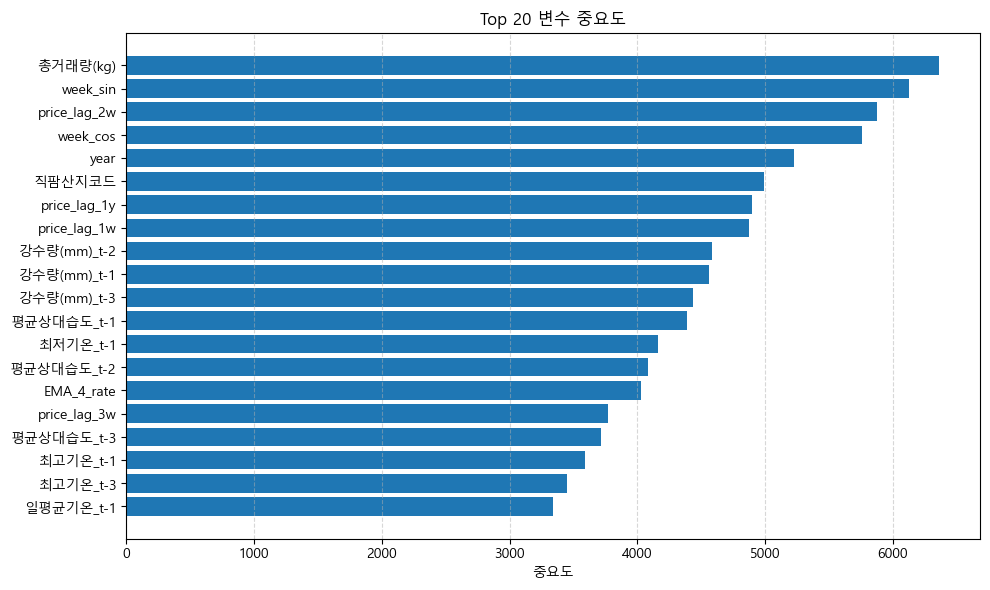

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# ‚úÖ 1. Î≥ÄÏàò Ï§ëÏöîÎèÑ Ï∂îÏ∂ú (Gain Í∏∞Ï§Ä)

importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_  # ‚úÖ LightGBMÏù¥Îì† RFÎì† OK
}).sort_values("importance", ascending=False).reset_index(drop=True)

# ÏãúÍ∞ÅÌôî
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"][:top_n][::-1], importance_df["importance"][:top_n][::-1])
plt.xlabel("Ï§ëÏöîÎèÑ")
plt.title(f"Top {top_n} Î≥ÄÏàò Ï§ëÏöîÎèÑ")
plt.tight_layout()
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()


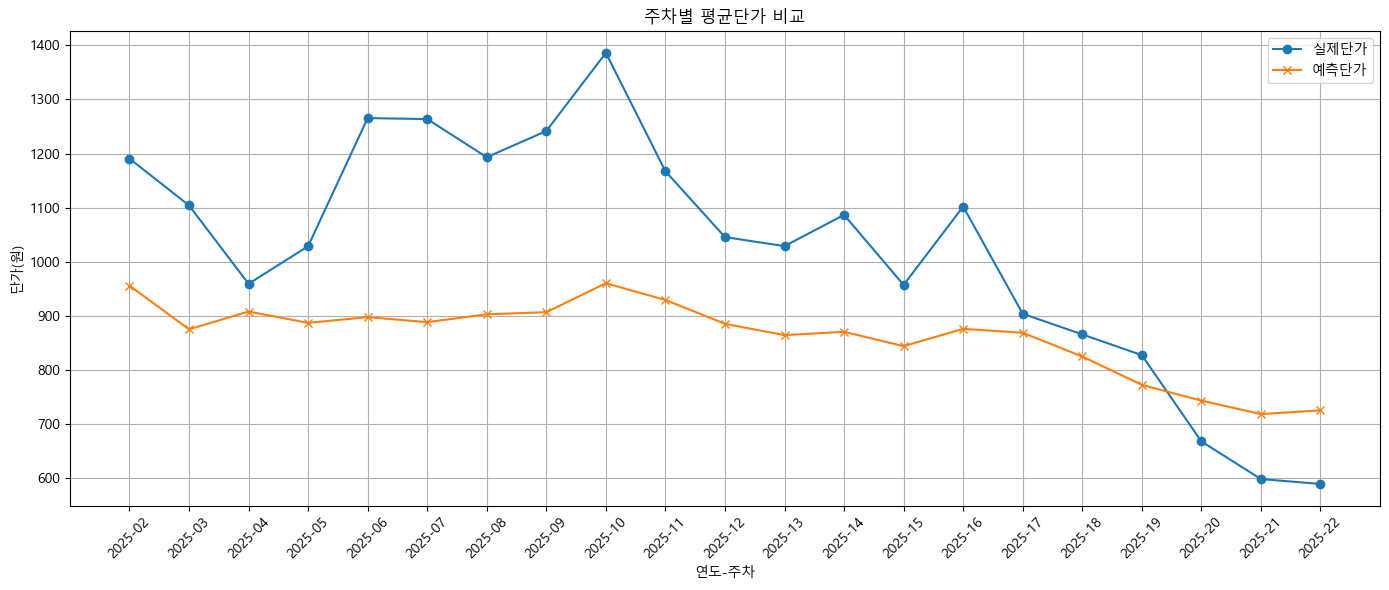

In [28]:
# 1. ÏòàÏ∏° Í≤∞Í≥ºÏôÄ Ïã§Ï†úÍ∞í Í≤∞Ìï©
df_result = pd.DataFrame({
    'index': y_test.index,
    'Ïã§Ï†úÎã®Í∞Ä': y_test.values,
    'ÏòàÏ∏°Îã®Í∞Ä': pred
})

# 2. ÏõêÎ≥∏ dfÏóêÏÑú 'year', 'week' Ïª¨ÎüºÎßå Ï∂îÏ∂úÌï¥ÏÑú join
df_meta = df[['year', 'week']].reset_index()  # ÏõêÎ≥∏ dfÏóêÏÑú ÎÇ†Ïßú Ï†ïÎ≥¥ Ï∂îÏ∂ú
df_result = df_result.merge(df_meta, how='left', on='index')  # index Í∏∞Ï§ÄÏúºÎ°ú ÎÇ†Ïßú Ï†ïÎ≥¥ Î≥ëÌï©

# 3. Ï£ºÏ∞®Î≥Ñ ÌèâÍ∑† Í≥ÑÏÇ∞
df_weekly = df_result.groupby(['year', 'week'])[['Ïã§Ï†úÎã®Í∞Ä', 'ÏòàÏ∏°Îã®Í∞Ä']].mean().reset_index()
# 1. yearÏôÄ weekÎ•º Î¨∏ÏûêÏó¥Î°ú Î∂ôÏù∏ ÏÉà Ïª¨Îüº ÏÉùÏÑ± (Ïòà: '2025-01')
df_weekly['Ïó∞ÎèÑÏ£ºÏ∞®'] = df_weekly['year'].astype(str) + '-' + df_weekly['week'].astype(str).str.zfill(2)


# 4. ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_weekly['Ïó∞ÎèÑÏ£ºÏ∞®'], df_weekly['Ïã§Ï†úÎã®Í∞Ä'], label='Ïã§Ï†úÎã®Í∞Ä', marker='o')
plt.plot(df_weekly['Ïó∞ÎèÑÏ£ºÏ∞®'], df_weekly['ÏòàÏ∏°Îã®Í∞Ä'], label='ÏòàÏ∏°Îã®Í∞Ä', marker='x')
plt.title('Ï£ºÏ∞®Î≥Ñ ÌèâÍ∑†Îã®Í∞Ä ÎπÑÍµê')
plt.xlabel('Ïó∞ÎèÑ-Ï£ºÏ∞®')
plt.ylabel('Îã®Í∞Ä(Ïõê)')
plt.xticks(rotation=45)  # xÏ∂ï ÎùºÎ≤®Ïù¥ Í≤πÏπòÏßÄ ÏïäÎèÑÎ°ù ÌöåÏ†Ñ
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()